<h2>Zomato Data Analytics</h2>
<p style="
  font-style:italic;
  color:#86868b;
  font-size:15px;
  letter-spacing:0.2px;
  margin-top:6px;
">
  Exploratory analysis of restaurant demand, pricing, cuisines, and city-wise trends
</p>


<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
     Business Value of Restaurant Analytics
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
  ">
    Restaurant analytics can be highly valuable for companies such as Swiggy and Zomato.
    It helps them understand which restaurants are in high demand, which cuisines are
    preferred across different cities, and how much revenue various locations contribute.
    Analytics also provides visibility into delivery coverage across multiple pin codes
    and how customers respond in different regions.
  </p>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
  ">
    Based on these insights, businesses can make more informed decisions, including:
  </p>

  <ul style="
    font-size:15px;
    line-height:1.8;
    color:#3a3a3c;
    padding-left:18px;
  ">
    <li>Optimizing restaurant and cuisine recommendations</li>
    <li>Improving delivery coverage across regions</li>
    <li>Designing city-specific marketing strategies</li>
    <li>Enhancing overall customer experience</li>
    <li>Helping restaurants grow through data-driven insights</li>
  </ul>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    In this project, restaurant data is explored to uncover meaningful insights related to
    demand patterns, pricing behavior, cuisines, ratings, and city-wise customer trends.
  </p>
</div>


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("rabhar/zomato-restaurants-in-india")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/zomato-restaurants-in-india


<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:10px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Dataset
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
  ">
    For this analysis, the <b>Zomato Restaurants in India</b> dataset from Kaggle was used.
    The dataset provides detailed information about restaurants across multiple Indian cities.
  </p>

  <ul style="
    font-size:15px;
    line-height:1.8;
    color:#3a3a3c;
    padding-left:18px;
  ">
    <li>Restaurant name</li>
    <li>City and location</li>
    <li>Cuisines offered</li>
    <li>Ratings and votes</li>
    <li>Average cost for two</li>
    <li>Delivery and dining details</li>
  </ul>

  <p style="
    font-size:14px;
    color:#6e6e73;
    margin-bottom:0;
  ">
    Dataset source: 
    <a href="https://www.kaggle.com/datasets/rabhar/zomato-restaurants-in-india" target="_blank" style="color:#0071e3; text-decoration:none;">
      Kaggle – Zomato Restaurants in India
    </a>
  </p>
</div>


In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
#Seaborn style setting
sns.set(style="whitegrid")


In [21]:
import os
os.listdir('/kaggle/input/zomato-restaurants-in-india')

['zomato_restaurants_in_India.csv']

In [22]:
#Load Data
df = pd.read_csv("/kaggle/input/zomato-restaurants-in-india/zomato_restaurants_in_India.csv")
df.head()
df.shape
df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211944 entries, 0 to 211943
Data columns (total 26 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   res_id                211944 non-null  int64  
 1   name                  211944 non-null  object 
 2   establishment         211944 non-null  object 
 3   url                   211944 non-null  object 
 4   address               211810 non-null  object 
 5   city                  211944 non-null  object 
 6   city_id               211944 non-null  int64  
 7   locality              211944 non-null  object 
 8   latitude              211944 non-null  float64
 9   longitude             211944 non-null  float64
 10  zipcode               48757 non-null   object 
 11  country_id            211944 non-null  int64  
 12  locality_verbose      211944 non-null  object 
 13  cuisines              210553 non-null  object 
 14  timings               208070 non-null  object 
 15  

In [23]:
df.columns


Index(['res_id', 'name', 'establishment', 'url', 'address', 'city', 'city_id',
       'locality', 'latitude', 'longitude', 'zipcode', 'country_id',
       'locality_verbose', 'cuisines', 'timings', 'average_cost_for_two',
       'price_range', 'currency', 'highlights', 'aggregate_rating',
       'rating_text', 'votes', 'photo_count', 'opentable_support', 'delivery',
       'takeaway'],
      dtype='object')

**Data Cleaning**

<h4 style="
  font-weight:600;
  color:#1d1d1f;
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
font-size : 15px
">
  Ensuring Consistent Data Types Across Features
</h4>


In [24]:

df.dtypes

res_id                    int64
name                     object
establishment            object
url                      object
address                  object
city                     object
city_id                   int64
locality                 object
latitude                float64
longitude               float64
zipcode                  object
country_id                int64
locality_verbose         object
cuisines                 object
timings                  object
average_cost_for_two      int64
price_range               int64
currency                 object
highlights               object
aggregate_rating        float64
rating_text              object
votes                     int64
photo_count               int64
opentable_support       float64
delivery                  int64
takeaway                  int64
dtype: object

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:10px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Delivery Column Interpretation
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
  ">
    Although the <code>delivery</code> column is stored as <code>int64</code>, it represents a 
    categorical attribute describing delivery availability. The encoded values 
    <code>-1</code>, <code>0</code>, and <code>1</code> correspond to unavailable, unknown, and 
    available states respectively. These values do not convey numerical magnitude or ordering, 
    and are therefore treated as categorical rather than numeric.
  </p>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    To maintain data integrity during iterative EDA, the original <code>delivery</code> column 
    was preserved in its encoded form. A separate human-readable column, 
    <code>delivery_label</code>, was introduced to improve interpretability in analysis and 
    visualizations.
  </p>
</div>


In [25]:
df['delivery'].unique()

array([-1,  1,  0])

In [26]:
#There are three values in column delivery. So we are counting how many occurences are there of each va;ue
df['delivery'].value_counts()


delivery
-1    132573
 1     78335
 0      1036
Name: count, dtype: int64

In [27]:
#Creating a transformed column: Creates a new column by applying value replacement and data type conversion 
#on an existing column, preserving the original data while storing the cleaned version separately.
df['delivery_label'] = (
    df['delivery']
    .replace({1: 'Yes', 0: 'Unknown', -1: 'No'})
    .astype('category')
)


In [28]:
#A new column delivery_label has been added
df.columns

Index(['res_id', 'name', 'establishment', 'url', 'address', 'city', 'city_id',
       'locality', 'latitude', 'longitude', 'zipcode', 'country_id',
       'locality_verbose', 'cuisines', 'timings', 'average_cost_for_two',
       'price_range', 'currency', 'highlights', 'aggregate_rating',
       'rating_text', 'votes', 'photo_count', 'opentable_support', 'delivery',
       'takeaway', 'delivery_label'],
      dtype='object')

In [29]:
df.dtypes

res_id                     int64
name                      object
establishment             object
url                       object
address                   object
city                      object
city_id                    int64
locality                  object
latitude                 float64
longitude                float64
zipcode                   object
country_id                 int64
locality_verbose          object
cuisines                  object
timings                   object
average_cost_for_two       int64
price_range                int64
currency                  object
highlights                object
aggregate_rating         float64
rating_text               object
votes                      int64
photo_count                int64
opentable_support        float64
delivery                   int64
takeaway                   int64
delivery_label          category
dtype: object

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Removing Irrelevant Columns
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
  ">
    The following columns do not add analytical value for exploratory data analysis (EDA):
  </p>

  <ul style="
    font-size:15px;
    line-height:1.8;
    color:#3a3a3c;
    padding-left:18px;
  ">
    <li>
      <b><code>url</code>:</b> This only contains the restaurant’s Zomato webpage link.
    </li>
    <li>
      <b><code>address</code>:</b> The address is a long unstructured text field. Most insights related to location
      can already be derived from structured fields such as <code>city</code>, <code>locality</code>,
      and <code>zipcode</code>.
    </li>
    <li>
      <b><code>city_id:</code></b> This is simply a numeric mapping of the <code>city</code> column. Since the city
      name itself is already available and more readable, <code>city_id</code> becomes redundant and
      unnecessary for analysis.
    </li>
    <li>
      <b><code>country_id:</code></b> This dataset only contains restaurants from India, so the country value
      remains the same for all rows.
    </li>
    <li>
      <b><code>locality_verbose</code>:</b> This is a detailed descriptive version of locality, but structured and
      cleaner <code>locality</code> and <code>city</code> columns are already available.
    </li>
    <li>
      <b><code>photo_count</code>:</b> Dropped because it reflects user engagement rather than restaurant quality
      or performance and does not contribute meaningful insights to the current analysis.
    </li>
    <li>
      <b><code>opentable_support</code>:</b> Dropped because it is not relevant to the Indian restaurant context
      and has minimal impact on pricing, ratings, or customer preference analysis.
    </li>
  </ul>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    These columns were dropped because they either serve as identifiers, URLs, redundant information,
    or unstructured text that does not contribute to meaningful insights in exploratory data analysis.
  </p>
</div>


In [30]:
df = df.drop(columns=['url','city_id','country_id','locality_verbose','address' ,'opentable_support' , 'photo_count' ])


In [31]:
df.columns

Index(['res_id', 'name', 'establishment', 'city', 'locality', 'latitude',
       'longitude', 'zipcode', 'cuisines', 'timings', 'average_cost_for_two',
       'price_range', 'currency', 'highlights', 'aggregate_rating',
       'rating_text', 'votes', 'delivery', 'takeaway', 'delivery_label'],
      dtype='object')

**Handling Missing Values**

In [32]:
#Calculate total number of missing values in each column
df.isnull().sum()


res_id                       0
name                         0
establishment                0
city                         0
locality                     0
latitude                     0
longitude                    0
zipcode                 163187
cuisines                  1391
timings                   3874
average_cost_for_two         0
price_range                  0
currency                     0
highlights                   0
aggregate_rating             0
rating_text                  0
votes                        0
delivery                     0
takeaway                     0
delivery_label               0
dtype: int64

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Handling Missing Values and Cleanup
  </h4>

  <ul style="
    font-size:15px;
    line-height:1.8;
    color:#3a3a3c;
    padding-left:18px;
    margin-bottom:0;
  ">
    <li>
      Removed <code>zipcode</code> because it had a very high percentage of missing values and
      offered limited analytical value.
    </li>
    <li>
      Dropped rows with missing <code>cuisines</code> since cuisine information is essential
      for meaningful analysis.
    </li>
    <li>
      Filled missing <code>timings</code> values with <i>Not Available</i>.
    </li>
    <li>
      Removed the <code>opentable_support</code> column as it is not relevant for analysis.
    </li>
  </ul>
</div>


In [33]:
df = df.drop(columns=['zipcode'])
df = df.dropna(subset=['cuisines'])
df['timings'] = df['timings'].fillna("Not Available")




In [34]:
df.dtypes

res_id                     int64
name                      object
establishment             object
city                      object
locality                  object
latitude                 float64
longitude                float64
cuisines                  object
timings                   object
average_cost_for_two       int64
price_range                int64
currency                  object
highlights                object
aggregate_rating         float64
rating_text               object
votes                      int64
delivery                   int64
takeaway                   int64
delivery_label          category
dtype: object

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Removing Duplicate Entries
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    Since multiple duplicate restaurant entries existed in the dataset, duplicates were identified
    using the unique <code>res_id</code> column. Only one entry per restaurant was retained, and
    the remaining duplicates were removed to ensure unbiased and accurate analysis.
  </p>
</div>


In [35]:
df['res_id'].duplicated().sum()


np.int64(155455)

In [36]:
df = df.drop_duplicates(subset=['res_id'])


In [37]:
df.shape

(55098, 19)

In [38]:

df['res_id'].duplicated().sum()

np.int64(0)

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Cleaning Ratings
  </h4>

  <ul style="
    font-size:15px;
    line-height:1.8;
    color:#3a3a3c;
    padding-left:18px;
    margin-bottom:0;
  ">
    <li>
      Some restaurants have <code>aggregate_rating = 0.0</code> but are actually marked as
      <i>Not Rated</i>.
    </li>
    <li>
      Some entries contain mismatches between <code>aggregate_rating</code> and
      <code>rating_text</code>.
    </li>
    <li>
      Restaurants with very few votes may have unreliable ratings.
    </li>
    <li>
      Ratings need to be ensured as numeric, consistent, and clean for analysis.
    </li>
  </ul>
</div>


In [39]:
df['rating_text'].info

<bound method Series.info of 0         Very Good
1         Very Good
2         Very Good
3         Very Good
4         Excellent
            ...    
211882      Average
211925    Very Good
211926         Good
211940    Very Good
211942         Good
Name: rating_text, Length: 55098, dtype: object>

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Dropping Redundant Rating Information
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    The <code>rating_text</code> column was dropped because it is simply a textual representation
    of the <code>aggregate_rating</code> column. Since <code>aggregate_rating</code> already
    provides a more precise and useful numerical value for analysis, retaining both columns
    would be redundant.
  </p>
</div>


In [40]:
df = df.drop(columns = 'rating_text')

In [41]:
df.columns

Index(['res_id', 'name', 'establishment', 'city', 'locality', 'latitude',
       'longitude', 'cuisines', 'timings', 'average_cost_for_two',
       'price_range', 'currency', 'highlights', 'aggregate_rating', 'votes',
       'delivery', 'takeaway', 'delivery_label'],
      dtype='object')

In [42]:
df['aggregate_rating'].info

<bound method Series.info of 0         4.4
1         4.4
2         4.2
3         4.3
4         4.9
         ... 
211882    2.9
211925    4.0
211926    3.9
211940    4.1
211942    3.7
Name: aggregate_rating, Length: 55098, dtype: float64>

In [43]:
df['aggregate_rating'].unique()

array([4.4, 4.2, 4.3, 4.9, 4. , 3.8, 3.4, 4.1, 3.5, 4.6, 3.9, 3.6, 4.5,
       4.7, 3.7, 4.8, 3.2, 0. , 3.3, 2.8, 3.1, 2.6, 3. , 2.7, 2.9, 2.2,
       2.3, 2.4, 2.5, 2.1, 1.8, 2. , 1.9])

In [44]:
df['aggregate_rating'].describe()

count    55098.000000
mean         2.979478
std          1.449025
min          0.000000
25%          2.900000
50%          3.500000
75%          3.900000
max          4.900000
Name: aggregate_rating, dtype: float64

In [45]:
#Check how many times rating 0 appears
(df['aggregate_rating'] == 0).sum()


np.int64(9662)

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Handling Unrated Restaurants
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    Restaurants with an <code>aggregate_rating</code> of <code>0.0</code> represent unrated
    establishments. Since these entries do not contribute meaningful information for
    rating-based analysis, they were removed from the dataset.
  </p>
</div>


In [46]:
df = df[df['aggregate_rating'] > 0]

In [47]:
df.shape

(45436, 18)

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Filtering Low-Vote Ratings
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    To improve the reliability of rating-based analysis, only restaurants with at least
    <code>5</code> votes were retained. Ratings derived from very few votes may not accurately
    represent overall customer sentiment and can introduce noise into the analysis.
  </p>
</div>


In [48]:
df['votes'].info

<bound method Series.info of 0          814
1         1203
2          801
3          693
4          470
          ... 
211882       4
211925     111
211926     207
211940     187
211942     128
Name: votes, Length: 45436, dtype: int64>

In [49]:
df = df[df['votes'] >= 5]

In [50]:
df.shape

(43149, 18)

In [51]:
df.dtypes

res_id                     int64
name                      object
establishment             object
city                      object
locality                  object
latitude                 float64
longitude                float64
cuisines                  object
timings                   object
average_cost_for_two       int64
price_range                int64
currency                  object
highlights                object
aggregate_rating         float64
votes                      int64
delivery                   int64
takeaway                   int64
delivery_label          category
dtype: object

In [52]:
df['price_range'].value_counts()

price_range
1    19695
2    14262
3     6623
4     2569
Name: count, dtype: int64

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Interpreting Price Range
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    The <code>price_range</code> column contains four distinct values and was treated as a
    categorical variable. In this encoding, <code>1</code> represents budget-friendly
    restaurants, while <code>4</code> represents expensive restaurants.
  </p>
</div>


In [53]:
df['price_range'] = df['price_range'].astype('category')

In [54]:
df['price_range'].dtypes

CategoricalDtype(categories=[1, 2, 3, 4], ordered=False, categories_dtype=int64)

In [79]:
df.dtypes

res_id                     int64
name                      object
establishment             object
city                      object
locality                  object
latitude                 float64
longitude                float64
cuisines                  object
timings                   object
average_cost_for_two       int64
price_range             category
currency                  object
highlights                object
aggregate_rating         float64
votes                      int64
delivery                   int64
takeaway                   int64
delivery_label          category
dtype: object

**avg_cost_for_two**

In [55]:
df['average_cost_for_two'].describe()

count    43149.000000
mean       592.702380
std        639.994149
min          0.000000
25%        250.000000
50%        400.000000
75%        700.000000
max      30000.000000
Name: average_cost_for_two, dtype: float64

99th percentile is the value below which 99% of the data lies

In [56]:
upper_limit = df['average_cost_for_two'].quantile(0.99)

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Removing Extreme Cost Outliers
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    The <code>99th percentile</code> value of <code>average_cost_for_two</code> was calculated
    and used as an upper limit. Restaurants with an average cost for two exceeding this
    threshold were removed to eliminate extreme outliers and improve the interpretability
    of the analysis.
  </p>
</div>


In [57]:
upper_limit

np.float64(3000.0)

In [58]:
df = df[df['average_cost_for_two'] <= upper_limit]

In [59]:
df['average_cost_for_two'].describe()

count    42779.000000
mean       558.951004
std        495.699505
min          0.000000
25%        250.000000
50%        400.000000
75%        700.000000
max       3000.000000
Name: average_cost_for_two, dtype: float64

**Working on currency**

In [60]:
df['currency'].value_counts()

currency
Rs.    42779
Name: count, dtype: int64

In [61]:
df = df.drop(columns = ['currency'])

All the values in currency Have same value Rs. So it is better to delete this column

In [62]:
df.dtypes

res_id                     int64
name                      object
establishment             object
city                      object
locality                  object
latitude                 float64
longitude                float64
cuisines                  object
timings                   object
average_cost_for_two       int64
price_range             category
highlights                object
aggregate_rating         float64
votes                      int64
delivery                   int64
takeaway                   int64
delivery_label          category
dtype: object

**City columns : Making city names consistent**

In [63]:
df['city'].unique()

array(['Agra', 'Ahmedabad', 'Gandhinagar', 'Ajmer', 'Alappuzha',
       'Allahabad', 'Amravati', 'Amritsar', 'Aurangabad', 'Bangalore',
       'Bhopal', 'Bhubaneshwar', 'Chandigarh', 'Mohali', 'Panchkula',
       'Zirakpur', 'Nayagaon', 'Chennai', 'Coimbatore', 'Cuttack',
       'Darjeeling', 'Dehradun', 'New Delhi', 'Gurgaon', 'Noida',
       'Faridabad', 'Ghaziabad', 'Greater Noida', 'Dharamshala',
       'Gangtok', 'Goa', 'Gorakhpur', 'Guntur', 'Guwahati', 'Gwalior',
       'Haridwar', 'Hyderabad', 'Secunderabad', 'Indore', 'Jabalpur',
       'Jaipur', 'Jalandhar', 'Jammu', 'Jamnagar', 'Jamshedpur', 'Jhansi',
       'Jodhpur', 'Junagadh', 'Kanpur', 'Kharagpur', 'Kochi', 'Kolhapur',
       'Kolkata', 'Howrah', 'Kota', 'Lucknow', 'Ludhiana', 'Madurai',
       'Manali', 'Mangalore', 'Manipal', 'Udupi', 'Meerut', 'Mumbai',
       'Thane', 'Navi Mumbai', 'Mussoorie', 'Mysore', 'Nagpur',
       'Nainital', 'Nasik', 'Nashik', 'Neemrana', 'Ooty', 'Palakkad',
       'Patiala', 'Patna', 'Pudu

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Standardizing City Names
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    Real-world datasets often contain inconsistencies in text fields due to varying naming
    conventions and spellings. To address this, manual inspection was performed to identify
    such variations, and domain knowledge was applied to standardize city names, ensuring
    accurate and reliable analysis.
  </p>
</div>


<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Normalizing and Validating City Names
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
  ">
    The dataset contained a total of <b>96 unique city names</b>. While this number is not
    excessively large, relying solely on manual inspection can still introduce human error
    and inconsistency.
  </p>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
  ">
    To reduce noise and standardize text before comparison, an initial normalization step
    was applied to city names:
  </p>

  <ul style="
    font-size:15px;
    line-height:1.8;
    color:#3a3a3c;
    padding-left:18px;
  ">
    <li>Converted to lowercase</li>
    <li>Stripped of leading and trailing whitespaces</li>
    <li>Deduplicated</li>
  </ul>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    This normalization ensures that superficial formatting differences do not affect similarity
    matching. After normalization, string similarity techniques using <code>difflib</code> were
    applied during EDA to identify potential duplicate or misspelled city names for further review.
  </p>
</div>


In [64]:
# Derive a normalized list of city names for analysis without modifying the original DataFrame,
# preserving raw data integrity during exploratory analysis
cities = df['city'].dropna().str.lower().str.strip().unique()

In [65]:
from difflib import SequenceMatcher

def similarity(a, b):
    return SequenceMatcher(None, a, b).ratio()

similar_pairs = []

for i in range(len(cities)):
    for j in range(i + 1, len(cities)):
        score = similarity(cities[i], cities[j])
        if score > 0.85 and cities[i] != cities[j]:
            similar_pairs.append((cities[i], cities[j], score))

In [66]:
similar_pairs

[('bangalore', 'mangalore', 0.8888888888888888),
 ('nasik', 'nashik', 0.9090909090909091)]

In [67]:
city_mapping = {
   
    'nasik': 'nashik'
}


In [68]:
df['city_cleaned'] = (
    df['city']
    .str.lower()
    .str.strip()
    .replace(city_mapping)
)

In [69]:
df.columns

Index(['res_id', 'name', 'establishment', 'city', 'locality', 'latitude',
       'longitude', 'cuisines', 'timings', 'average_cost_for_two',
       'price_range', 'highlights', 'aggregate_rating', 'votes', 'delivery',
       'takeaway', 'delivery_label', 'city_cleaned'],
      dtype='object')

In [70]:
df["cuisines"]

0         North Indian, South Indian, Mithai, Street Foo...
1         North Indian, Mughlai, Rolls, Chinese, Fast Fo...
2                                         Fast Food, Mithai
3                 Desserts, Bakery, Fast Food, South Indian
4                        North Indian, Continental, Italian
                                ...                        
211881                                North Indian, Chinese
211925                      Gujarati, North Indian, Chinese
211926                                Gujarati, Street Food
211940                                            Fast Food
211942                           Fast Food, Sandwich, Salad
Name: cuisines, Length: 42779, dtype: object

In [71]:
df['cuisines'].head()

0    North Indian, South Indian, Mithai, Street Foo...
1    North Indian, Mughlai, Rolls, Chinese, Fast Fo...
2                                    Fast Food, Mithai
3            Desserts, Bakery, Fast Food, South Indian
4                   North Indian, Continental, Italian
Name: cuisines, dtype: object

<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="
    margin-top:0;
    margin-bottom:12px;
    font-weight:600;
    color:#1d1d1f;
  ">
    Cleaning the Cuisines Column
  </h4>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
  ">
    A cleaned version of the <code>cuisines</code> column was created by normalizing whitespace,
    converting empty or whitespace-only values to <code>NaN</code>, and trimming leading and
    trailing spaces.
  </p>

  <ul style="
    font-size:15px;
    line-height:1.8;
    color:#3a3a3c;
    padding-left:18px;
  ">
    <li>Normalized multiple spaces using <code>.str.replace(r'\s+', ' ', regex=True)</code></li>
    <li>Converted empty or whitespace-only entries to <code>NaN</code> using <code>.replace(r'^\s*$', np.nan, regex=True)</code></li>
    <li>Trimmed leading and trailing spaces using <code>.str.strip()</code></li>
  </ul>

  <p style="
    font-size:15px;
    line-height:1.7;
    color:#3a3a3c;
    margin-bottom:0;
  ">
    The original <code>cuisines</code> column was preserved to maintain raw data integrity.
  </p>
</div>


In [72]:
df['cuisines_cleaned'] = (
    df['cuisines']
    .str.replace(r'\s+', ' ', regex=True)
    .replace(r'^\s*$', np.nan, regex=True)
    .str.strip()
)

In [73]:
df.columns

Index(['res_id', 'name', 'establishment', 'city', 'locality', 'latitude',
       'longitude', 'cuisines', 'timings', 'average_cost_for_two',
       'price_range', 'highlights', 'aggregate_rating', 'votes', 'delivery',
       'takeaway', 'delivery_label', 'city_cleaned', 'cuisines_cleaned'],
      dtype='object')

<Axes: xlabel='votes', ylabel='aggregate_rating'>

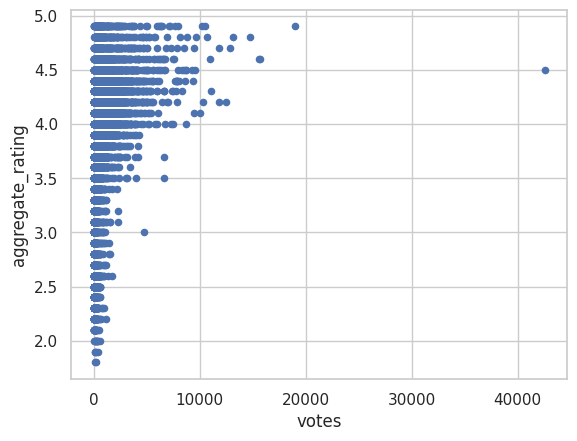

In [74]:
df.plot.scatter(x='votes', y='aggregate_rating')


<div style="
  padding:22px;
  border-radius:14px;
  background:#ffffff;
  box-shadow:0 4px 12px rgba(0,0,0,0.06);
  font-family:-apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, sans-serif;
">
  <h4 style="margin-top:0; margin-bottom:12px; font-weight:600; color:#1d1d1f;">
    Ratings vs Votes — Observations
  </h4>

  <p style="font-size:15px; line-height:1.7; color:#3a3a3c;">
    The scatter plot highlights several clear patterns in the relationship between the
    number of votes and aggregate ratings.
  </p>

  <p style="font-size:15px; line-height:1.7; color:#3a3a3c;">
    <b>• Heavy clustering at low vote counts:</b>  
    Most restaurants have received a relatively small number of votes. In this low-vote region,
    ratings vary widely, ranging approximately from 2.0 to 4.9, indicating high variability and
    lower reliability.
  </p>

  <p style="font-size:15px; line-height:1.7; color:#3a3a3c;">
    <b>• High variance in ratings for low-vote restaurants:</b>  
    Restaurants with very few votes often display extreme ratings (both high and low), suggesting
    that ratings based on limited feedback may be unstable or biased.
  </p>

  <p style="font-size:15px; line-height:1.7; color:#3a3a3c;">
    <b>• Stabilization of ratings as votes increase:</b>  
    As the number of votes increases into the thousands, ratings begin to concentrate within a
    narrower range, roughly between 3.8 and 4.6, with noticeably reduced variance.
  </p>

  <p style="font-size:15px; line-height:1.7; color:#3a3a3c;">
    <b>• Absence of extreme ratings at high vote counts:</b>  
    Restaurants with very large numbers of votes rarely achieve extreme ratings, indicating that
    increased participation leads to more balanced and representative evaluations.
  </p>

  <p style="font-size:15px; line-height:1.7; color:#3a3a3c; margin-bottom:0;">
    Overall, the plot suggests that vote count plays a crucial role in determining the reliability
    of aggregate ratings, with higher vote counts providing greater confidence in the observed
    rating values.
  </p>
</div>
